In [1]:
import torch
import torch.nn as nn

from utils import *

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

Files already downloaded and verified
Files already downloaded and verified


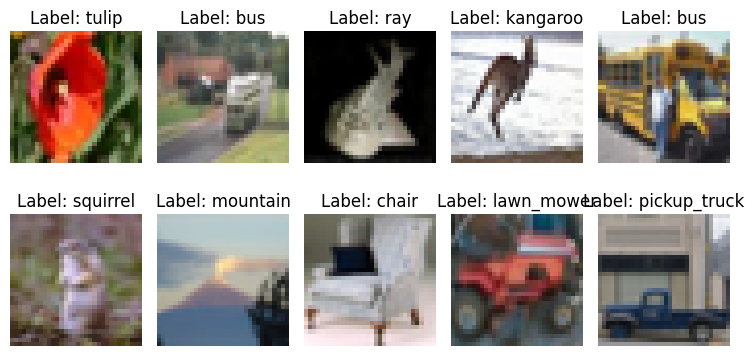

Labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willo

In [2]:
# Load and display dataset. Available datasets: MNIST, FMNIST, CIFAR10, CIFAR100

ds_name = "CIFAR100"
trainset, trainloader, valloader, testloader, input_size, num_classes = get_img_dataset(ds_name, batch_size=256)
classes = trainset.classes

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display images in a grid
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))

for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(images[i].permute(1, 2, 0) / 2 + 0.5, cmap='gray')  # Unnormalize and display
    ax.set_title(f'Label: {classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Labels: {classes}')

In [3]:
def train_and_test(model, trainloader, valloader, testloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    # Train & validation

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        train_acc = 0
        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, input_size).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()
                
                # Print individual training samples (e.g. [1/60000])
                #sample_number = (i - 1) * trainloader.batch_size + len(images)
                #print(f"Epoch {epoch}: [{sample_number}/{len(trainloader.dataset)}]")

        train_losses.append(train_loss / len(trainloader))
        train_accs.append(train_acc / len(trainloader))

        t = time()-start
        times.append(t)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(trainloader):.4f}, Train Accuracy: {train_acc / len(trainloader):.4f}, Time: {t:.2f}s")
        

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, input_size).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

            val_losses.append(val_loss / len(valloader))
            val_accs.append(val_acc / len(valloader))

            print(f"\t      Valid Loss: {val_loss / len(valloader):.4f}, Valid Accuracy: {val_acc / len(valloader):.4f}\n")


    # Test

    model.eval()
    with torch.no_grad():
        test_loss = 0
        test_acc = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.view(-1, input_size).to(device)
            output = model(images)

            test_loss += criterion(output, labels.to(device)).item()
            test_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        print(f'Test Loss: {test_loss / len(testloader):.4f}, Test Accuracy: {test_acc / len(testloader):.4f}\n')


    return train_losses, train_accs, val_losses, val_accs, test_loss/len(testloader), test_acc/len(testloader), times

In [4]:
def build_data_frame(model, num_epochs, train_losses, train_accs, val_losses, val_accs, time, separator):

    df = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        })
    
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Mean', 'Time': df['Time'].mean()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Total', 'Time': df['Time'].sum()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df = pd.concat([df, separator], ignore_index=True)

    return df

In [5]:
# Define models and parameters

model_list_mlp = [
    MyMLP([input_size, 1024, num_classes]),
    MyMLP([input_size, 1024, 256, num_classes]),
    MyMLP([input_size, 512, num_classes]),
    MyMLP([input_size, 10, num_classes]),
    MyMLP([input_size, 10, 10, num_classes]),
    MyMLP([input_size, 5, 5, num_classes]),
    ]
model_list_kan = [
    MyKAN([input_size, 1024, num_classes], grid_size=3),
    MyKAN([input_size, 1024, 256, num_classes], grid_size=3),
    MyKAN([input_size, 512, num_classes], grid_size=3),
    MyKAN([input_size, 10, num_classes], grid_size=3),
    MyKAN([input_size, 10, 10, num_classes], grid_size=3),
    MyKAN([input_size, 5, 5, num_classes], grid_size=3),
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp, df_kan = [pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time']) for _ in range(2)]
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

lists = [[] for _ in range(12)]
total_train_losses_mlp, total_train_accs_mlp, total_val_losses_mlp, total_val_accs_mlp, total_train_losses_kan, total_train_accs_kan, total_val_losses_kan, total_val_accs_kan, test_accs_mlp, test_accs_kan, num_params_mlp, num_params_kan = lists

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, test_loss_mlp, test_acc_mlp, time_mlp = train_and_test(model_mlp, trainloader, valloader, testloader, device, num_epochs, optimizer_mlp, criterion)
    total_train_losses_mlp.append(train_losses_mlp)
    total_train_accs_mlp.append(train_accs_mlp)
    total_val_losses_mlp.append(val_losses_mlp)
    total_val_accs_mlp.append(val_accs_mlp)
    test_accs_mlp.append(test_acc_mlp)
    num_params_mlp.append(model_mlp.num_parameters)


    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, test_loss_kan, test_acc_kan, time_kan = train_and_test(model_kan, trainloader, valloader, testloader, device, num_epochs, optimizer_kan, criterion)
    total_train_losses_kan.append(train_losses_kan)
    total_train_accs_kan.append(train_accs_kan)
    total_val_losses_kan.append(val_losses_kan)
    total_val_accs_kan.append(val_accs_kan)
    test_accs_kan.append(test_acc_kan)
    num_params_kan.append(model_kan.num_parameters)

    single_df_mlp = build_data_frame(model_mlp, num_epochs, train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp, separator)
    single_df_kan = build_data_frame(model_kan, num_epochs, train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan, separator)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" [3072, 1024, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 3249252



100%|██████████| 157/157 [00:05<00:00, 30.81it/s]


Epoch [1/10], Train Loss: 3.7946, Train Accuracy: 0.1415, Time: 5.10s
	      Valid Loss: 3.5752, Valid Accuracy: 0.1783



100%|██████████| 157/157 [00:04<00:00, 33.32it/s]


Epoch [2/10], Train Loss: 3.3276, Train Accuracy: 0.2162, Time: 4.71s
	      Valid Loss: 3.4957, Valid Accuracy: 0.1939



100%|██████████| 157/157 [00:04<00:00, 33.42it/s]


Epoch [3/10], Train Loss: 3.0597, Train Accuracy: 0.2691, Time: 4.70s
	      Valid Loss: 3.4691, Valid Accuracy: 0.2116



100%|██████████| 157/157 [00:04<00:00, 33.78it/s]


Epoch [4/10], Train Loss: 2.8499, Train Accuracy: 0.3083, Time: 4.65s
	      Valid Loss: 3.4338, Valid Accuracy: 0.2302



100%|██████████| 157/157 [00:05<00:00, 31.22it/s]


Epoch [5/10], Train Loss: 2.6359, Train Accuracy: 0.3508, Time: 5.03s
	      Valid Loss: 3.5379, Valid Accuracy: 0.2327



100%|██████████| 157/157 [00:04<00:00, 32.40it/s]


Epoch [6/10], Train Loss: 2.4439, Train Accuracy: 0.3958, Time: 4.85s
	      Valid Loss: 3.5747, Valid Accuracy: 0.2308



100%|██████████| 157/157 [00:04<00:00, 31.48it/s]


Epoch [7/10], Train Loss: 2.2299, Train Accuracy: 0.4412, Time: 4.99s
	      Valid Loss: 3.6738, Valid Accuracy: 0.2282



100%|██████████| 157/157 [00:05<00:00, 31.28it/s]


Epoch [8/10], Train Loss: 2.0511, Train Accuracy: 0.4800, Time: 5.02s
	      Valid Loss: 3.7146, Valid Accuracy: 0.2373



100%|██████████| 157/157 [00:04<00:00, 31.71it/s]


Epoch [9/10], Train Loss: 1.8801, Train Accuracy: 0.5228, Time: 4.95s
	      Valid Loss: 3.8560, Valid Accuracy: 0.2371



100%|██████████| 157/157 [00:04<00:00, 32.34it/s]


Epoch [10/10], Train Loss: 1.7127, Train Accuracy: 0.5622, Time: 4.86s
	      Valid Loss: 3.9540, Valid Accuracy: 0.2325

Test Loss: 3.9532, Test Accuracy: 0.2363

Training model "MyKAN" [3072, 1024, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 9744384



100%|██████████| 157/157 [00:06<00:00, 23.25it/s]


Epoch [1/10], Train Loss: 3.6956, Train Accuracy: 0.1491, Time: 6.75s
	      Valid Loss: 3.4249, Valid Accuracy: 0.1944



100%|██████████| 157/157 [00:06<00:00, 23.05it/s]


Epoch [2/10], Train Loss: 3.1309, Train Accuracy: 0.2481, Time: 6.81s
	      Valid Loss: 3.1912, Valid Accuracy: 0.2400



100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Epoch [3/10], Train Loss: 2.7823, Train Accuracy: 0.3140, Time: 6.69s
	      Valid Loss: 3.1275, Valid Accuracy: 0.2534



100%|██████████| 157/157 [00:06<00:00, 23.76it/s]


Epoch [4/10], Train Loss: 2.4698, Train Accuracy: 0.3759, Time: 6.61s
	      Valid Loss: 3.0802, Valid Accuracy: 0.2722



100%|██████████| 157/157 [00:06<00:00, 23.75it/s]


Epoch [5/10], Train Loss: 2.1740, Train Accuracy: 0.4453, Time: 6.61s
	      Valid Loss: 3.1218, Valid Accuracy: 0.2702



100%|██████████| 157/157 [00:06<00:00, 23.89it/s]


Epoch [6/10], Train Loss: 1.8642, Train Accuracy: 0.5182, Time: 6.57s
	      Valid Loss: 3.1834, Valid Accuracy: 0.2782



100%|██████████| 157/157 [00:06<00:00, 23.64it/s]


Epoch [7/10], Train Loss: 1.5645, Train Accuracy: 0.5938, Time: 6.64s
	      Valid Loss: 3.3050, Valid Accuracy: 0.2768



100%|██████████| 157/157 [00:06<00:00, 23.23it/s]


Epoch [8/10], Train Loss: 1.2861, Train Accuracy: 0.6667, Time: 6.76s
	      Valid Loss: 3.4144, Valid Accuracy: 0.2785



100%|██████████| 157/157 [00:06<00:00, 23.69it/s]


Epoch [9/10], Train Loss: 1.0310, Train Accuracy: 0.7356, Time: 6.63s
	      Valid Loss: 3.5490, Valid Accuracy: 0.2726



100%|██████████| 157/157 [00:06<00:00, 23.63it/s]


Epoch [10/10], Train Loss: 0.7999, Train Accuracy: 0.7999, Time: 6.65s
	      Valid Loss: 3.7014, Valid Accuracy: 0.2677

Test Loss: 3.6742, Test Accuracy: 0.2708

Training model "MyMLP" [3072, 1024, 256, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 3434852



100%|██████████| 157/157 [00:04<00:00, 32.34it/s]


Epoch [1/10], Train Loss: 3.8135, Train Accuracy: 0.1276, Time: 4.86s
	      Valid Loss: 3.5950, Valid Accuracy: 0.1605



100%|██████████| 157/157 [00:04<00:00, 32.11it/s]


Epoch [2/10], Train Loss: 3.3694, Train Accuracy: 0.2002, Time: 4.89s
	      Valid Loss: 3.4221, Valid Accuracy: 0.1928



100%|██████████| 157/157 [00:04<00:00, 32.11it/s]


Epoch [3/10], Train Loss: 3.1339, Train Accuracy: 0.2436, Time: 4.89s
	      Valid Loss: 3.3352, Valid Accuracy: 0.2117



100%|██████████| 157/157 [00:05<00:00, 28.50it/s]


Epoch [4/10], Train Loss: 2.9426, Train Accuracy: 0.2772, Time: 5.51s
	      Valid Loss: 3.3263, Valid Accuracy: 0.2279



100%|██████████| 157/157 [00:05<00:00, 29.84it/s]


Epoch [5/10], Train Loss: 2.7647, Train Accuracy: 0.3097, Time: 5.26s
	      Valid Loss: 3.2398, Valid Accuracy: 0.2400



100%|██████████| 157/157 [00:05<00:00, 29.66it/s]


Epoch [6/10], Train Loss: 2.5854, Train Accuracy: 0.3470, Time: 5.29s
	      Valid Loss: 3.3501, Valid Accuracy: 0.2369



100%|██████████| 157/157 [00:05<00:00, 27.92it/s]


Epoch [7/10], Train Loss: 2.4125, Train Accuracy: 0.3850, Time: 5.62s
	      Valid Loss: 3.3461, Valid Accuracy: 0.2432



100%|██████████| 157/157 [00:05<00:00, 27.78it/s]


Epoch [8/10], Train Loss: 2.2351, Train Accuracy: 0.4200, Time: 5.65s
	      Valid Loss: 3.4292, Valid Accuracy: 0.2498



100%|██████████| 157/157 [00:05<00:00, 27.87it/s]


Epoch [9/10], Train Loss: 2.0590, Train Accuracy: 0.4593, Time: 5.64s
	      Valid Loss: 3.4807, Valid Accuracy: 0.2462



100%|██████████| 157/157 [00:05<00:00, 27.32it/s]


Epoch [10/10], Train Loss: 1.8939, Train Accuracy: 0.4969, Time: 5.75s
	      Valid Loss: 3.6511, Valid Accuracy: 0.2406

Test Loss: 3.6199, Test Accuracy: 0.2522

Training model "MyKAN" [3072, 1024, 256, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 10300416



100%|██████████| 157/157 [00:07<00:00, 19.72it/s]


Epoch [1/10], Train Loss: 3.7244, Train Accuracy: 0.1386, Time: 7.96s
	      Valid Loss: 3.4165, Valid Accuracy: 0.1861



100%|██████████| 157/157 [00:07<00:00, 19.97it/s]


Epoch [2/10], Train Loss: 3.1669, Train Accuracy: 0.2315, Time: 7.86s
	      Valid Loss: 3.1902, Valid Accuracy: 0.2307



100%|██████████| 157/157 [00:08<00:00, 18.82it/s]


Epoch [3/10], Train Loss: 2.8211, Train Accuracy: 0.2951, Time: 8.35s
	      Valid Loss: 3.0432, Valid Accuracy: 0.2586



100%|██████████| 157/157 [00:07<00:00, 21.83it/s]


Epoch [4/10], Train Loss: 2.5096, Train Accuracy: 0.3592, Time: 7.19s
	      Valid Loss: 3.0397, Valid Accuracy: 0.2611



100%|██████████| 157/157 [00:08<00:00, 18.34it/s]


Epoch [5/10], Train Loss: 2.2059, Train Accuracy: 0.4252, Time: 8.56s
	      Valid Loss: 3.0634, Valid Accuracy: 0.2780



100%|██████████| 157/157 [00:08<00:00, 18.78it/s]


Epoch [6/10], Train Loss: 1.8802, Train Accuracy: 0.5012, Time: 8.36s
	      Valid Loss: 3.1362, Valid Accuracy: 0.2840



100%|██████████| 157/157 [00:08<00:00, 18.31it/s]


Epoch [7/10], Train Loss: 1.5540, Train Accuracy: 0.5797, Time: 8.57s
	      Valid Loss: 3.3009, Valid Accuracy: 0.2838



100%|██████████| 157/157 [00:08<00:00, 18.56it/s]


Epoch [8/10], Train Loss: 1.2298, Train Accuracy: 0.6687, Time: 8.46s
	      Valid Loss: 3.4592, Valid Accuracy: 0.2769



100%|██████████| 157/157 [00:08<00:00, 19.37it/s]


Epoch [9/10], Train Loss: 0.9384, Train Accuracy: 0.7468, Time: 8.11s
	      Valid Loss: 3.6989, Valid Accuracy: 0.2812



100%|██████████| 157/157 [00:07<00:00, 19.69it/s]


Epoch [10/10], Train Loss: 0.6841, Train Accuracy: 0.8176, Time: 7.97s
	      Valid Loss: 3.9236, Valid Accuracy: 0.2746

Test Loss: 3.9369, Test Accuracy: 0.2810

Training model "MyMLP" [3072, 512, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 1624676



100%|██████████| 157/157 [00:05<00:00, 27.44it/s]


Epoch [1/10], Train Loss: 3.7770, Train Accuracy: 0.1411, Time: 5.72s
	      Valid Loss: 3.5612, Valid Accuracy: 0.1799



100%|██████████| 157/157 [00:05<00:00, 26.57it/s]


Epoch [2/10], Train Loss: 3.3280, Train Accuracy: 0.2168, Time: 5.91s
	      Valid Loss: 3.4537, Valid Accuracy: 0.2022



100%|██████████| 157/157 [00:05<00:00, 27.25it/s]


Epoch [3/10], Train Loss: 3.0891, Train Accuracy: 0.2592, Time: 5.76s
	      Valid Loss: 3.4244, Valid Accuracy: 0.2136



100%|██████████| 157/157 [00:05<00:00, 28.08it/s]


Epoch [4/10], Train Loss: 2.9002, Train Accuracy: 0.2979, Time: 5.59s
	      Valid Loss: 3.3804, Valid Accuracy: 0.2242



100%|██████████| 157/157 [00:05<00:00, 28.31it/s]


Epoch [5/10], Train Loss: 2.7246, Train Accuracy: 0.3310, Time: 5.55s
	      Valid Loss: 3.3674, Valid Accuracy: 0.2349



100%|██████████| 157/157 [00:05<00:00, 28.16it/s]


Epoch [6/10], Train Loss: 2.5655, Train Accuracy: 0.3652, Time: 5.58s
	      Valid Loss: 3.3737, Valid Accuracy: 0.2449



100%|██████████| 157/157 [00:05<00:00, 28.76it/s]


Epoch [7/10], Train Loss: 2.4180, Train Accuracy: 0.3964, Time: 5.46s
	      Valid Loss: 3.4182, Valid Accuracy: 0.2359



100%|██████████| 157/157 [00:05<00:00, 29.39it/s]


Epoch [8/10], Train Loss: 2.2590, Train Accuracy: 0.4323, Time: 5.34s
	      Valid Loss: 3.4946, Valid Accuracy: 0.2355



100%|██████████| 157/157 [00:05<00:00, 29.50it/s]


Epoch [9/10], Train Loss: 2.1298, Train Accuracy: 0.4602, Time: 5.32s
	      Valid Loss: 3.5971, Valid Accuracy: 0.2291



100%|██████████| 157/157 [00:05<00:00, 29.81it/s]


Epoch [10/10], Train Loss: 1.9986, Train Accuracy: 0.4924, Time: 5.27s
	      Valid Loss: 3.6362, Valid Accuracy: 0.2431

Test Loss: 3.6408, Test Accuracy: 0.2337

Training model "MyKAN" [3072, 512, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 4872192



100%|██████████| 157/157 [00:06<00:00, 23.83it/s]


Epoch [1/10], Train Loss: 3.7216, Train Accuracy: 0.1450, Time: 6.59s
	      Valid Loss: 3.4614, Valid Accuracy: 0.1886



100%|██████████| 157/157 [00:06<00:00, 24.05it/s]


Epoch [2/10], Train Loss: 3.1975, Train Accuracy: 0.2364, Time: 6.53s
	      Valid Loss: 3.2540, Valid Accuracy: 0.2277



100%|██████████| 157/157 [00:06<00:00, 24.08it/s]


Epoch [3/10], Train Loss: 2.8939, Train Accuracy: 0.2927, Time: 6.52s
	      Valid Loss: 3.1646, Valid Accuracy: 0.2466



100%|██████████| 157/157 [00:06<00:00, 24.15it/s]


Epoch [4/10], Train Loss: 2.6432, Train Accuracy: 0.3446, Time: 6.50s
	      Valid Loss: 3.0881, Valid Accuracy: 0.2647



100%|██████████| 157/157 [00:06<00:00, 24.20it/s]


Epoch [5/10], Train Loss: 2.4082, Train Accuracy: 0.3965, Time: 6.49s
	      Valid Loss: 3.1208, Valid Accuracy: 0.2631



100%|██████████| 157/157 [00:06<00:00, 24.16it/s]


Epoch [6/10], Train Loss: 2.1828, Train Accuracy: 0.4449, Time: 6.50s
	      Valid Loss: 3.1394, Valid Accuracy: 0.2642



100%|██████████| 157/157 [00:06<00:00, 24.16it/s]


Epoch [7/10], Train Loss: 1.9611, Train Accuracy: 0.4972, Time: 6.50s
	      Valid Loss: 3.1910, Valid Accuracy: 0.2697



100%|██████████| 157/157 [00:06<00:00, 23.70it/s]


Epoch [8/10], Train Loss: 1.7513, Train Accuracy: 0.5488, Time: 6.63s
	      Valid Loss: 3.2501, Valid Accuracy: 0.2665



100%|██████████| 157/157 [00:06<00:00, 24.09it/s]


Epoch [9/10], Train Loss: 1.5402, Train Accuracy: 0.6028, Time: 6.52s
	      Valid Loss: 3.3629, Valid Accuracy: 0.2664



100%|██████████| 157/157 [00:06<00:00, 24.07it/s]


Epoch [10/10], Train Loss: 1.3483, Train Accuracy: 0.6539, Time: 6.53s
	      Valid Loss: 3.4396, Valid Accuracy: 0.2645

Test Loss: 3.3940, Test Accuracy: 0.2728

Training model "MyMLP" [3072, 10, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 31830



100%|██████████| 157/157 [00:05<00:00, 29.70it/s]


Epoch [1/10], Train Loss: 4.4671, Train Accuracy: 0.0325, Time: 5.29s
	      Valid Loss: 4.3026, Valid Accuracy: 0.0486



100%|██████████| 157/157 [00:05<00:00, 29.75it/s]


Epoch [2/10], Train Loss: 4.1504, Train Accuracy: 0.0673, Time: 5.28s
	      Valid Loss: 4.0891, Valid Accuracy: 0.0696



100%|██████████| 157/157 [00:05<00:00, 29.90it/s]


Epoch [3/10], Train Loss: 3.9907, Train Accuracy: 0.0878, Time: 5.25s
	      Valid Loss: 3.9864, Valid Accuracy: 0.0868



100%|██████████| 157/157 [00:05<00:00, 29.54it/s]


Epoch [4/10], Train Loss: 3.9090, Train Accuracy: 0.1019, Time: 5.32s
	      Valid Loss: 3.9344, Valid Accuracy: 0.0996



100%|██████████| 157/157 [00:05<00:00, 30.39it/s]


Epoch [5/10], Train Loss: 3.8507, Train Accuracy: 0.1089, Time: 5.17s
	      Valid Loss: 3.8792, Valid Accuracy: 0.1125



100%|██████████| 157/157 [00:04<00:00, 32.40it/s]


Epoch [6/10], Train Loss: 3.8045, Train Accuracy: 0.1160, Time: 4.85s
	      Valid Loss: 3.8521, Valid Accuracy: 0.1146



100%|██████████| 157/157 [00:04<00:00, 32.24it/s]


Epoch [7/10], Train Loss: 3.7696, Train Accuracy: 0.1219, Time: 4.87s
	      Valid Loss: 3.8300, Valid Accuracy: 0.1183



100%|██████████| 157/157 [00:04<00:00, 32.54it/s]


Epoch [8/10], Train Loss: 3.7435, Train Accuracy: 0.1258, Time: 4.83s
	      Valid Loss: 3.8014, Valid Accuracy: 0.1227



100%|██████████| 157/157 [00:04<00:00, 32.11it/s]


Epoch [9/10], Train Loss: 3.7234, Train Accuracy: 0.1306, Time: 4.89s
	      Valid Loss: 3.8037, Valid Accuracy: 0.1258



100%|██████████| 157/157 [00:04<00:00, 32.28it/s]


Epoch [10/10], Train Loss: 3.7025, Train Accuracy: 0.1357, Time: 4.87s
	      Valid Loss: 3.7799, Valid Accuracy: 0.1274

Test Loss: 3.8017, Test Accuracy: 0.1270

Training model "MyKAN" [3072, 10, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 95160



100%|██████████| 157/157 [00:05<00:00, 28.73it/s]


Epoch [1/10], Train Loss: 4.4503, Train Accuracy: 0.0360, Time: 5.47s
	      Valid Loss: 4.2696, Valid Accuracy: 0.0608



100%|██████████| 157/157 [00:05<00:00, 28.91it/s]


Epoch [2/10], Train Loss: 4.0767, Train Accuracy: 0.0773, Time: 5.43s
	      Valid Loss: 3.9584, Valid Accuracy: 0.0938



100%|██████████| 157/157 [00:05<00:00, 28.57it/s]


Epoch [3/10], Train Loss: 3.8408, Train Accuracy: 0.1139, Time: 5.50s
	      Valid Loss: 3.8131, Valid Accuracy: 0.1175



100%|██████████| 157/157 [00:05<00:00, 26.97it/s]


Epoch [4/10], Train Loss: 3.7279, Train Accuracy: 0.1336, Time: 5.82s
	      Valid Loss: 3.7376, Valid Accuracy: 0.1312



100%|██████████| 157/157 [00:05<00:00, 28.57it/s]


Epoch [5/10], Train Loss: 3.6539, Train Accuracy: 0.1475, Time: 5.50s
	      Valid Loss: 3.7034, Valid Accuracy: 0.1389



100%|██████████| 157/157 [00:05<00:00, 26.86it/s]


Epoch [6/10], Train Loss: 3.6030, Train Accuracy: 0.1549, Time: 5.85s
	      Valid Loss: 3.6742, Valid Accuracy: 0.1429



100%|██████████| 157/157 [00:05<00:00, 27.29it/s]


Epoch [7/10], Train Loss: 3.5619, Train Accuracy: 0.1636, Time: 5.76s
	      Valid Loss: 3.6451, Valid Accuracy: 0.1481



100%|██████████| 157/157 [00:05<00:00, 27.38it/s]


Epoch [8/10], Train Loss: 3.5287, Train Accuracy: 0.1727, Time: 5.73s
	      Valid Loss: 3.6321, Valid Accuracy: 0.1518



100%|██████████| 157/157 [00:05<00:00, 27.32it/s]


Epoch [9/10], Train Loss: 3.4998, Train Accuracy: 0.1768, Time: 5.75s
	      Valid Loss: 3.6144, Valid Accuracy: 0.1592



100%|██████████| 157/157 [00:05<00:00, 27.36it/s]


Epoch [10/10], Train Loss: 3.4742, Train Accuracy: 0.1816, Time: 5.74s
	      Valid Loss: 3.6066, Valid Accuracy: 0.1568

Test Loss: 3.6217, Test Accuracy: 0.1598

Training model "MyMLP" [3072, 10, 10, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 31940



100%|██████████| 157/157 [00:05<00:00, 31.06it/s]


Epoch [1/10], Train Loss: 4.5196, Train Accuracy: 0.0266, Time: 5.06s
	      Valid Loss: 4.3612, Valid Accuracy: 0.0474



100%|██████████| 157/157 [00:05<00:00, 30.74it/s]


Epoch [2/10], Train Loss: 4.2166, Train Accuracy: 0.0603, Time: 5.11s
	      Valid Loss: 4.0930, Valid Accuracy: 0.0763



100%|██████████| 157/157 [00:05<00:00, 31.02it/s]


Epoch [3/10], Train Loss: 4.0063, Train Accuracy: 0.0849, Time: 5.06s
	      Valid Loss: 3.9671, Valid Accuracy: 0.0881



100%|██████████| 157/157 [00:05<00:00, 31.01it/s]


Epoch [4/10], Train Loss: 3.8995, Train Accuracy: 0.0964, Time: 5.06s
	      Valid Loss: 3.8953, Valid Accuracy: 0.0968



100%|██████████| 157/157 [00:05<00:00, 31.06it/s]


Epoch [5/10], Train Loss: 3.8398, Train Accuracy: 0.1068, Time: 5.06s
	      Valid Loss: 3.8530, Valid Accuracy: 0.1053



100%|██████████| 157/157 [00:05<00:00, 30.14it/s]


Epoch [6/10], Train Loss: 3.7962, Train Accuracy: 0.1145, Time: 5.21s
	      Valid Loss: 3.8245, Valid Accuracy: 0.1145



100%|██████████| 157/157 [00:05<00:00, 30.12it/s]


Epoch [7/10], Train Loss: 3.7651, Train Accuracy: 0.1201, Time: 5.21s
	      Valid Loss: 3.7981, Valid Accuracy: 0.1208



100%|██████████| 157/157 [00:05<00:00, 30.44it/s]


Epoch [8/10], Train Loss: 3.7383, Train Accuracy: 0.1246, Time: 5.16s
	      Valid Loss: 3.7847, Valid Accuracy: 0.1160



100%|██████████| 157/157 [00:05<00:00, 30.51it/s]


Epoch [9/10], Train Loss: 3.7164, Train Accuracy: 0.1282, Time: 5.15s
	      Valid Loss: 3.7628, Valid Accuracy: 0.1255



100%|██████████| 157/157 [00:05<00:00, 30.61it/s]


Epoch [10/10], Train Loss: 3.6979, Train Accuracy: 0.1306, Time: 5.13s
	      Valid Loss: 3.7552, Valid Accuracy: 0.1238

Test Loss: 3.7665, Test Accuracy: 0.1231

Training model "MyKAN" [3072, 10, 10, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 95460



100%|██████████| 157/157 [00:05<00:00, 26.66it/s]


Epoch [1/10], Train Loss: 4.4408, Train Accuracy: 0.0332, Time: 5.89s
	      Valid Loss: 4.2641, Valid Accuracy: 0.0523



100%|██████████| 157/157 [00:05<00:00, 26.62it/s]


Epoch [2/10], Train Loss: 4.1159, Train Accuracy: 0.0667, Time: 5.90s
	      Valid Loss: 4.0188, Valid Accuracy: 0.0760



100%|██████████| 157/157 [00:05<00:00, 26.78it/s]


Epoch [3/10], Train Loss: 3.9279, Train Accuracy: 0.0948, Time: 5.86s
	      Valid Loss: 3.8936, Valid Accuracy: 0.0994



100%|██████████| 157/157 [00:05<00:00, 26.85it/s]


Epoch [4/10], Train Loss: 3.8171, Train Accuracy: 0.1133, Time: 5.85s
	      Valid Loss: 3.8185, Valid Accuracy: 0.1153



100%|██████████| 157/157 [00:05<00:00, 26.85it/s]


Epoch [5/10], Train Loss: 3.7441, Train Accuracy: 0.1247, Time: 5.85s
	      Valid Loss: 3.7783, Valid Accuracy: 0.1182



100%|██████████| 157/157 [00:05<00:00, 26.69it/s]


Epoch [6/10], Train Loss: 3.6859, Train Accuracy: 0.1324, Time: 5.88s
	      Valid Loss: 3.7362, Valid Accuracy: 0.1304



100%|██████████| 157/157 [00:05<00:00, 26.52it/s]


Epoch [7/10], Train Loss: 3.6425, Train Accuracy: 0.1401, Time: 5.92s
	      Valid Loss: 3.7107, Valid Accuracy: 0.1326



100%|██████████| 157/157 [00:05<00:00, 26.71it/s]


Epoch [8/10], Train Loss: 3.6049, Train Accuracy: 0.1492, Time: 5.88s
	      Valid Loss: 3.6859, Valid Accuracy: 0.1398



100%|██████████| 157/157 [00:05<00:00, 26.61it/s]


Epoch [9/10], Train Loss: 3.5713, Train Accuracy: 0.1539, Time: 5.90s
	      Valid Loss: 3.6677, Valid Accuracy: 0.1415



100%|██████████| 157/157 [00:05<00:00, 26.66it/s]


Epoch [10/10], Train Loss: 3.5426, Train Accuracy: 0.1583, Time: 5.89s
	      Valid Loss: 3.6527, Valid Accuracy: 0.1438

Test Loss: 3.6692, Test Accuracy: 0.1384

Training model "MyMLP" [3072, 5, 5, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 15995



100%|██████████| 157/157 [00:05<00:00, 31.04it/s]


Epoch [1/10], Train Loss: 4.5967, Train Accuracy: 0.0179, Time: 5.06s
	      Valid Loss: 4.5452, Valid Accuracy: 0.0254



100%|██████████| 157/157 [00:05<00:00, 29.94it/s]


Epoch [2/10], Train Loss: 4.4671, Train Accuracy: 0.0365, Time: 5.25s
	      Valid Loss: 4.4014, Valid Accuracy: 0.0396



100%|██████████| 157/157 [00:05<00:00, 29.68it/s]


Epoch [3/10], Train Loss: 4.3245, Train Accuracy: 0.0429, Time: 5.29s
	      Valid Loss: 4.2817, Valid Accuracy: 0.0442



100%|██████████| 157/157 [00:05<00:00, 30.11it/s]


Epoch [4/10], Train Loss: 4.2183, Train Accuracy: 0.0469, Time: 5.22s
	      Valid Loss: 4.2005, Valid Accuracy: 0.0515



100%|██████████| 157/157 [00:05<00:00, 30.18it/s]


Epoch [5/10], Train Loss: 4.1493, Train Accuracy: 0.0559, Time: 5.20s
	      Valid Loss: 4.1573, Valid Accuracy: 0.0565



100%|██████████| 157/157 [00:05<00:00, 30.14it/s]


Epoch [6/10], Train Loss: 4.1060, Train Accuracy: 0.0625, Time: 5.21s
	      Valid Loss: 4.1188, Valid Accuracy: 0.0611



100%|██████████| 157/157 [00:05<00:00, 30.27it/s]


Epoch [7/10], Train Loss: 4.0773, Train Accuracy: 0.0683, Time: 5.19s
	      Valid Loss: 4.1029, Valid Accuracy: 0.0653



100%|██████████| 157/157 [00:05<00:00, 30.55it/s]


Epoch [8/10], Train Loss: 4.0539, Train Accuracy: 0.0715, Time: 5.14s
	      Valid Loss: 4.0828, Valid Accuracy: 0.0687



100%|██████████| 157/157 [00:05<00:00, 29.83it/s]


Epoch [9/10], Train Loss: 4.0352, Train Accuracy: 0.0741, Time: 5.26s
	      Valid Loss: 4.0653, Valid Accuracy: 0.0702



100%|██████████| 157/157 [00:05<00:00, 30.21it/s]


Epoch [10/10], Train Loss: 4.0207, Train Accuracy: 0.0749, Time: 5.20s
	      Valid Loss: 4.0552, Valid Accuracy: 0.0716

Test Loss: 4.0614, Test Accuracy: 0.0746

Training model "MyKAN" [3072, 5, 5, 100] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 47655



100%|██████████| 157/157 [00:06<00:00, 25.29it/s]


Epoch [1/10], Train Loss: 4.5056, Train Accuracy: 0.0259, Time: 6.21s
	      Valid Loss: 4.3994, Valid Accuracy: 0.0400



100%|██████████| 157/157 [00:06<00:00, 25.15it/s]


Epoch [2/10], Train Loss: 4.3071, Train Accuracy: 0.0458, Time: 6.24s
	      Valid Loss: 4.2276, Valid Accuracy: 0.0531



100%|██████████| 157/157 [00:06<00:00, 25.24it/s]


Epoch [3/10], Train Loss: 4.1628, Train Accuracy: 0.0610, Time: 6.22s
	      Valid Loss: 4.1193, Valid Accuracy: 0.0686



100%|██████████| 157/157 [00:06<00:00, 25.24it/s]


Epoch [4/10], Train Loss: 4.0705, Train Accuracy: 0.0720, Time: 6.22s
	      Valid Loss: 4.0653, Valid Accuracy: 0.0707



100%|██████████| 157/157 [00:06<00:00, 25.71it/s]


Epoch [5/10], Train Loss: 4.0050, Train Accuracy: 0.0813, Time: 6.11s
	      Valid Loss: 4.0063, Valid Accuracy: 0.0804



100%|██████████| 157/157 [00:06<00:00, 25.19it/s]


Epoch [6/10], Train Loss: 3.9537, Train Accuracy: 0.0918, Time: 6.23s
	      Valid Loss: 3.9734, Valid Accuracy: 0.0846



100%|██████████| 157/157 [00:06<00:00, 24.44it/s]


Epoch [7/10], Train Loss: 3.9082, Train Accuracy: 0.0947, Time: 6.43s
	      Valid Loss: 3.9426, Valid Accuracy: 0.0898



100%|██████████| 157/157 [00:06<00:00, 24.52it/s]


Epoch [8/10], Train Loss: 3.8719, Train Accuracy: 0.0995, Time: 6.40s
	      Valid Loss: 3.9384, Valid Accuracy: 0.0918



100%|██████████| 157/157 [00:06<00:00, 25.28it/s]


Epoch [9/10], Train Loss: 3.8420, Train Accuracy: 0.1020, Time: 6.21s
	      Valid Loss: 3.8942, Valid Accuracy: 0.0997



100%|██████████| 157/157 [00:06<00:00, 24.61it/s]


Epoch [10/10], Train Loss: 3.8155, Train Accuracy: 0.1051, Time: 6.38s
	      Valid Loss: 3.8798, Valid Accuracy: 0.1020

Test Loss: 3.8738, Test Accuracy: 0.1040



In [6]:
print(test_accs_mlp)
print(test_accs_kan)

[0.236328125, 0.25224609375, 0.23369140625, 0.126953125, 0.12314453125, 0.074609375]
[0.27080078125, 0.28095703125, 0.27275390625, 0.159765625, 0.13837890625, 0.10400390625]


In [7]:
df_mlp.to_csv('results/image classification/results_mlp.csv', index = False)
df_kan.to_csv('results/image classification/results_kan.csv', index = False)

Plotting loss and accuracy wrt to epochs

In [18]:
def display_plots_epochs(ds_name, model_list, total_train_losses, total_val_losses, total_train_accs, total_val_accs, num_epochs):
    '''
    Displays train/validation loss and accuracy w.r.t epochs.
    '''

    fig, ax = plt.subplots(1,2, figsize=(8,4))

    colors = plt.cm.tab10.colors

    for i, model in enumerate(model_list):

        base_color = colors[i % len(colors)]
        
        ax[0].plot(range(1, num_epochs + 1), total_train_losses[i], color=base_color, alpha=0.33)
        ax[0].plot(range(1, num_epochs + 1), total_val_losses[i], label=f'MLP{model.layers}', color=base_color)
        
        ax[1].plot(range(1, num_epochs + 1), total_train_accs[i], color=base_color, alpha=0.33)
        ax[1].plot(range(1, num_epochs + 1), total_val_accs[i], label=f'MLP{model.layers}', color=base_color)

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title(f'{ds_name} - Train and Valid. Loss')
    ax[0].legend()

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title(f'{ds_name} - Train and Valid. Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

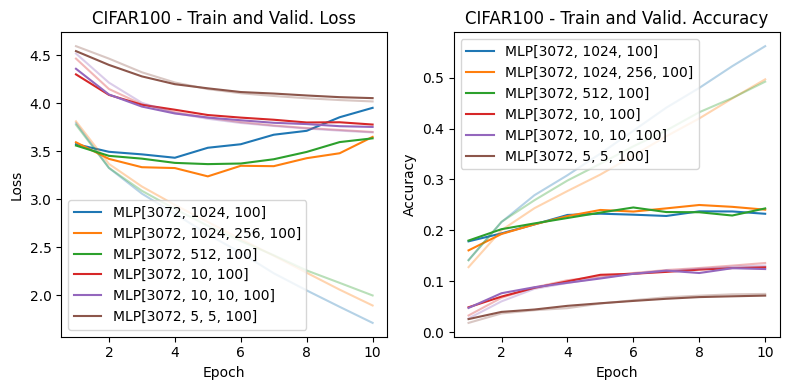

In [19]:
display_plots_epochs(ds_name, model_list_mlp, total_train_losses_mlp, total_val_losses_mlp, total_train_accs_mlp, total_val_accs_mlp, num_epochs)

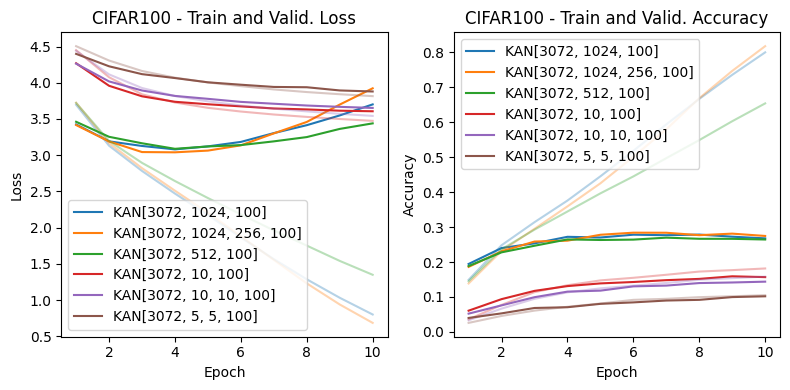

In [10]:
display_plots_epochs(ds_name, model_list_kan, total_train_losses_kan, total_val_losses_kan, total_train_accs_kan, total_val_accs_kan, num_epochs)

[0.074609375, 0.126953125, 0.12314453125, 0.23369140625, 0.236328125, 0.25224609375]
[0.10400390625, 0.159765625, 0.13837890625, 0.27275390625, 0.27080078125, 0.28095703125]
[15995, 31830, 31940, 1624676, 3249252, 3434852]
[47655, 95160, 95460, 4872192, 9744384, 10300416]


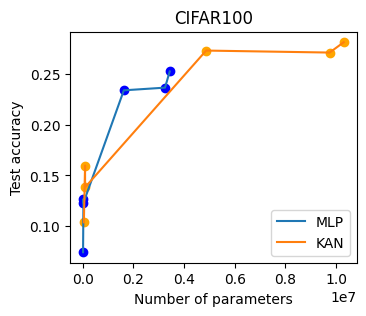

In [11]:
display_plots_params(ds_name, test_accs_mlp, test_accs_kan, num_params_mlp, num_params_kan)

In [12]:
def display_plots_params_enhanced(ds_name, models_layers_mlp, models_layers_kan, test_accs_mlp, test_accs_kan, num_params_mlp, num_params_kan):
    '''
    Displays test accuracy w.r.t. number of parameters, highlighting if the model is shallow (S) or deep (D).
    '''

    num_params_mlp, test_accs_mlp, models_layers_mlp = sort_by_params(num_params_mlp, test_accs_mlp, models_layers_mlp)
    num_params_kan, test_accs_kan, models_layers_kan = sort_by_params(num_params_kan, test_accs_kan, models_layers_kan)

    print(models_layers_mlp)
    print(num_params_mlp)
    print(test_accs_mlp)
    print()
    print(models_layers_kan)
    print(num_params_kan)
    print(test_accs_kan)

    fig, ax = plt.subplots(figsize=(3.5,3))

    for i in range(len(models_layers_mlp)):
        ax.scatter(num_params_mlp[i], test_accs_mlp[i], color='blue', marker=shallow_or_deep(models_layers_mlp[i]))
        ax.scatter(num_params_kan[i], test_accs_kan[i], color='orange', marker=shallow_or_deep(models_layers_kan[i]))

    ax.plot(num_params_mlp, test_accs_mlp, label='MLP', alpha=0.4)
    ax.plot(num_params_kan, test_accs_kan, label='KAN', alpha=0.4)

    ticks = [14000, 120000, 330000]
    ax.set_xticks(ticks)
    ax.set_xticklabels(['~14,000', '~120,000', '~330,000'], rotation=45, ha="right")

    ax.legend(loc='lower right')
    ax.set_xlabel('Number of parameters')
    ax.set_ylabel('Test accuracy')
    ax.set_title(ds_name)

[[3072, 5, 5, 100], [3072, 10, 100], [3072, 10, 10, 100], [3072, 512, 100], [3072, 1024, 100], [3072, 1024, 256, 100]]
[15995, 31830, 31940, 1624676, 3249252, 3434852]
[0.074609375, 0.126953125, 0.12314453125, 0.23369140625, 0.236328125, 0.25224609375]

[[3072, 5, 5, 100], [3072, 10, 100], [3072, 10, 10, 100], [3072, 512, 100], [3072, 1024, 100], [3072, 1024, 256, 100]]
[47655, 95160, 95460, 4872192, 9744384, 10300416]
[0.10400390625, 0.159765625, 0.13837890625, 0.27275390625, 0.27080078125, 0.28095703125]


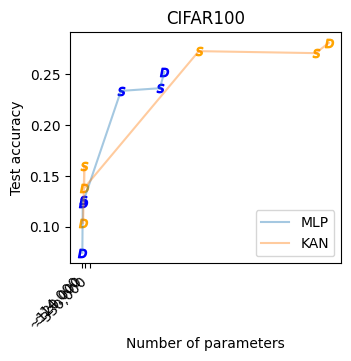

In [13]:
# inputs 2 and 3 are lists composed of the models' layer structure, e.g. [[784,128,10],[784,64,10],...]
display_plots_params_enhanced(ds_name, [i.layers for i in model_list_mlp], [i.layers for i in model_list_kan], test_accs_mlp, test_accs_kan, num_params_mlp, num_params_kan)

In [14]:
'''grid_sizes = [2,3,5,10,20,50,100,200,500]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

lists = [[] for _ in range(8)]
total_train_losses, total_train_accs, total_test_losses, total_test_accs, best_train_loss, best_train_acc, best_test_loss, best_test_acc = lists

for gs in grid_sizes:

    model_kan = MyKAN([input_size, 10, num_classes], grid_size=gs)

    optimizer = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses, train_accs, test_losses, test_accs, _ = train_and_test(model_kan, trainloader, testloader, device, num_epochs, optimizer, criterion)
    total_train_losses.append(train_losses)
    total_train_accs.append(train_accs)
    total_test_losses.append(test_losses)
    total_test_accs.append(test_accs)
    best_test_acc.append(test_accs[num_epochs-1])
    best_test_loss.append(test_losses[num_epochs-1])
    best_train_loss.append(train_losses[num_epochs-1])
    best_train_acc.append(train_accs[num_epochs-1])'''

'grid_sizes = [2,3,5,10,20,50,100,200,500]\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n#device = \'cpu\'\n\nnum_epochs = 10\nlearning_rate = 0.001\ncriterion = nn.CrossEntropyLoss()\n\nlists = [[] for _ in range(8)]\ntotal_train_losses, total_train_accs, total_test_losses, total_test_accs, best_train_loss, best_train_acc, best_test_loss, best_test_acc = lists\n\nfor gs in grid_sizes:\n\n    model_kan = MyKAN([input_size, 10, num_classes], grid_size=gs)\n\n    optimizer = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)\n    train_losses, train_accs, test_losses, test_accs, _ = train_and_test(model_kan, trainloader, testloader, device, num_epochs, optimizer, criterion)\n    total_train_losses.append(train_losses)\n    total_train_accs.append(train_accs)\n    total_test_losses.append(test_losses)\n    total_test_accs.append(test_accs)\n    best_test_acc.append(test_accs[num_epochs-1])\n    best_test_loss.append(test_losses[num_epochs-1])\n    best_

In [15]:
'''print(total_train_losses)
print(total_train_accs)
print(total_test_losses)
print(total_test_accs)
print(best_test_acc)
print(best_test_loss)
print(grid_sizes)'''

'print(total_train_losses)\nprint(total_train_accs)\nprint(total_test_losses)\nprint(total_test_accs)\nprint(best_test_acc)\nprint(best_test_loss)\nprint(grid_sizes)'

In [16]:
'''def display_plots_grid(ds_name, grid_sizes, best_train_loss, best_train_acc, best_test_loss, best_test_acc):
    
    #Displays test loss change w.r.t. grid size.
    

    fig, ax = plt.subplots(figsize=(5,4))
        
    ax.plot(range(0, len(grid_sizes)), best_train_loss, label='Train')
    ax.plot(range(0, len(grid_sizes)), best_test_loss, label='Test')

    ax.set_xticks([i for i in range(len(grid_sizes))])
    ax.set_xticklabels(grid_sizes, rotation=45, ha="right")

    ax.set_xlabel('Grid size')
    ax.set_ylabel('Loss')
    ax.set_title(f'{ds_name} - KAN[784, 10, 10]')
    ax.legend()

    plt.tight_layout()
    plt.show()'''

'def display_plots_grid(ds_name, grid_sizes, best_train_loss, best_train_acc, best_test_loss, best_test_acc):\n    \n    #Displays test loss change w.r.t. grid size.\n    \n\n    fig, ax = plt.subplots(figsize=(5,4))\n        \n    ax.plot(range(0, len(grid_sizes)), best_train_loss, label=\'Train\')\n    ax.plot(range(0, len(grid_sizes)), best_test_loss, label=\'Test\')\n\n    ax.set_xticks([i for i in range(len(grid_sizes))])\n    ax.set_xticklabels(grid_sizes, rotation=45, ha="right")\n\n    ax.set_xlabel(\'Grid size\')\n    ax.set_ylabel(\'Loss\')\n    ax.set_title(f\'{ds_name} - KAN[784, 10, 10]\')\n    ax.legend()\n\n    plt.tight_layout()\n    plt.show()'

In [17]:
'''display_plots_grid(ds_name, grid_sizes, best_train_loss, best_train_acc, best_test_loss, best_test_acc)'''

'display_plots_grid(ds_name, grid_sizes, best_train_loss, best_train_acc, best_test_loss, best_test_acc)'